:::{index} single: Model Structure
:::
:::{index} single: Model Structure; Simultaneous block
:::
:::{index} single: Model Structure; Recursive Block
:::
:::{index} Recursive block
:::
:::{index} Equation dependencies
:::
:::{index} Variable dependencies
:::

In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


# Model analytics


A model has a well defined logical and causal structure. {cite:author}`kogiku_introduction_1968`(1968) provides an introduction to causal analysis of models, while {cite:author}`berndsen_causal_1995`(1995) gives a more elaborate discussion. 

At the simplest level, the equations of a model can be organized into blocks. 

* **Simultaneous block** include equations that have are co-determined simultaneously. They contain feedback loops that may require several iterations before a solution that satisfies them all is found. A classic simultaneous block would include GDP, Income and Consumption. Consumption depends on income. Income depends on GDP, but Consumption also determines GDP. 

* **Recursive blocks** include equations that are a simple function of other variables. For example, the current account balance is just the difference between Export Revenues and Import Revenues.  These can be solved with just one pass once the values of the simultaneous blocks have been resolved.

At the equation level, each endogenous variable is a function of one or more variables, but because some of these variables are also dependent on other variables in the model, those right hand side variables that are endogenous can have their equations substituted into the first level equation to get an extended set of dependencies.  Moreover, the endogenous right hand side variables of these second level variables can also have their right hand sides substituted into the equation etc.


`ModelFlow` uses the [networkx](https://networkx.org/) python package to analyze the interrelationships within the model and between equations and includes a number of methods and properties to present these interrelationships both in tabular and graphical form [^graphviz], a subset of which is exposed in this chapter. 

[^graphviz]:The relational graphs produced by `ModelFlow` use the Graphviz [https://graphviz.org/](https://graphviz.org/) program, and are based on the relationships determined by the Networkx package. 

## Setting up the python environment and loading a pre-existing model

:::{admonition} In this chapter - Model Analytics
:class: tip

This chapter introduces tools and techniques for analyzing the structure and behavior of models in the `ModelFlow` framework. In a system of equations like World Bank models, impacts on variables in a simulation can be both the direct effect of changes imposed on variables in the equation of a variable, but also indirect effects caused by changes in variables that are not in the equation of a specific variable, but do generate changes in variables that are in the equation.

The chapter presents tools that explore the structure of a model, and display both the direct and indirect determinants of given equations.  

Following a simulation, the routines presented can display the precise contribution of a given variable to the change in another.

In addition to displaying which variables impacted a given variable, the routines can also be used to understand which variables are most impacted by changes in a given variable.

Results can be displayed both graphically and in tabular form.
:::


In [2]:
# Prepare the notebook for use of ModelFlow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of ModelFlow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

In [3]:
mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1)

mpak.model_description="World Bank climate aware model of Pakistan as described in Burns et al. (2019)"

Zipped file read:  ..\models\pak.pcim


:::{index} Model Information
:::
:::{index} single: Model Information; Model Name
:::
:::{index} Model Name
:::
:::{index} single: Model Information; Model Structure
:::
:::{index} Model Structure
:::
:::{index} single: Model Information; Number of equations
:::
:::{index} Number of equations in model
:::
:::{index} single: Model Information; Number of variables 
:::
:::{index} Number of variables in model
:::
:::{index} single: Model Information; Number of endogenous variables
:::
:::{index} Number of endogenous variables in model
:::

:::{index} single: Model Information; Number of exogenous variables
:::
:::{index} Number of exogenous variables in model
:::

In [4]:
latex=True # Enables the charts in latex 

:::{note}
**png=latex** 

The default behavior when displaying graphs in a *jupyter notebook* is to produce images in .svg format.
These images scale well and the mouseover feature can be used. That is: On mouseover of a node, the variable and the equation are displayed.  On mouseover on a joining line, the extent to which the variable contributed to the change in the dependent variable is displayed.

Unfortunately this *jupyter book* (book -- not notebook) requires images be in the jpg or PNG format so this functionality has been disabled, by specifying that the png format be used instead of svg.

For other purposes, the variable latex could be set equal to False in which case the same code will generate graphics in the more versatile SVG format.
:::

## Model information

As noted before, the model object contains information about the model itself, its name, its structure (does it contain simultaneous equations or is it recursive), the number of variables it contains and the number that are exogenous and endogenous (have associated equations).

In [5]:
mpak

<
Model name                              :                  PAK 
Model structure                         :         Simultaneous 
Number of variables                     :                  839 
Number of exogeneous  variables         :                  461 
Number of endogeneous variables         :                  378 
>

## Model structure  

A quick way to visualize the structure of a model is to plot its adjacency matrix [(https://en.wikipedia.org/wiki/Adjacency_matrix)](https://en.wikipedia.org/wiki/Adjacency_matrix). 

The adjacency matrix plots the relationships between endogenous variables in the model, dividing them into one or more simultaneous blocks and one or more recursive blocks.

Below is the adjacency matrix for the Pakistan model. Variables in the red square block (simultaneous block) depend on one or more variables that in turn depend upon them, requiring the model to solve for their values simultaneously.  The variables in the green triangles (recursive blocks) do not enter directly or indirectly as an argument in the variables that determine them and therefore can be solved in one iteration once the values for the simultaneous variables are determined.

:::{index} Model Structure
:::
:::{index} Model Adjacency matrix
:::
:::{index} Recursive equation block
:::
:::{index} Simultaneous equation block 
:::
:::{index} single: Model Structure; Model Adjacency matrix
:::
:::{index} single: Model Structure; Recursive equation block
:::
:::{index} single: Model Structure; Simultaneous equation block 
:::

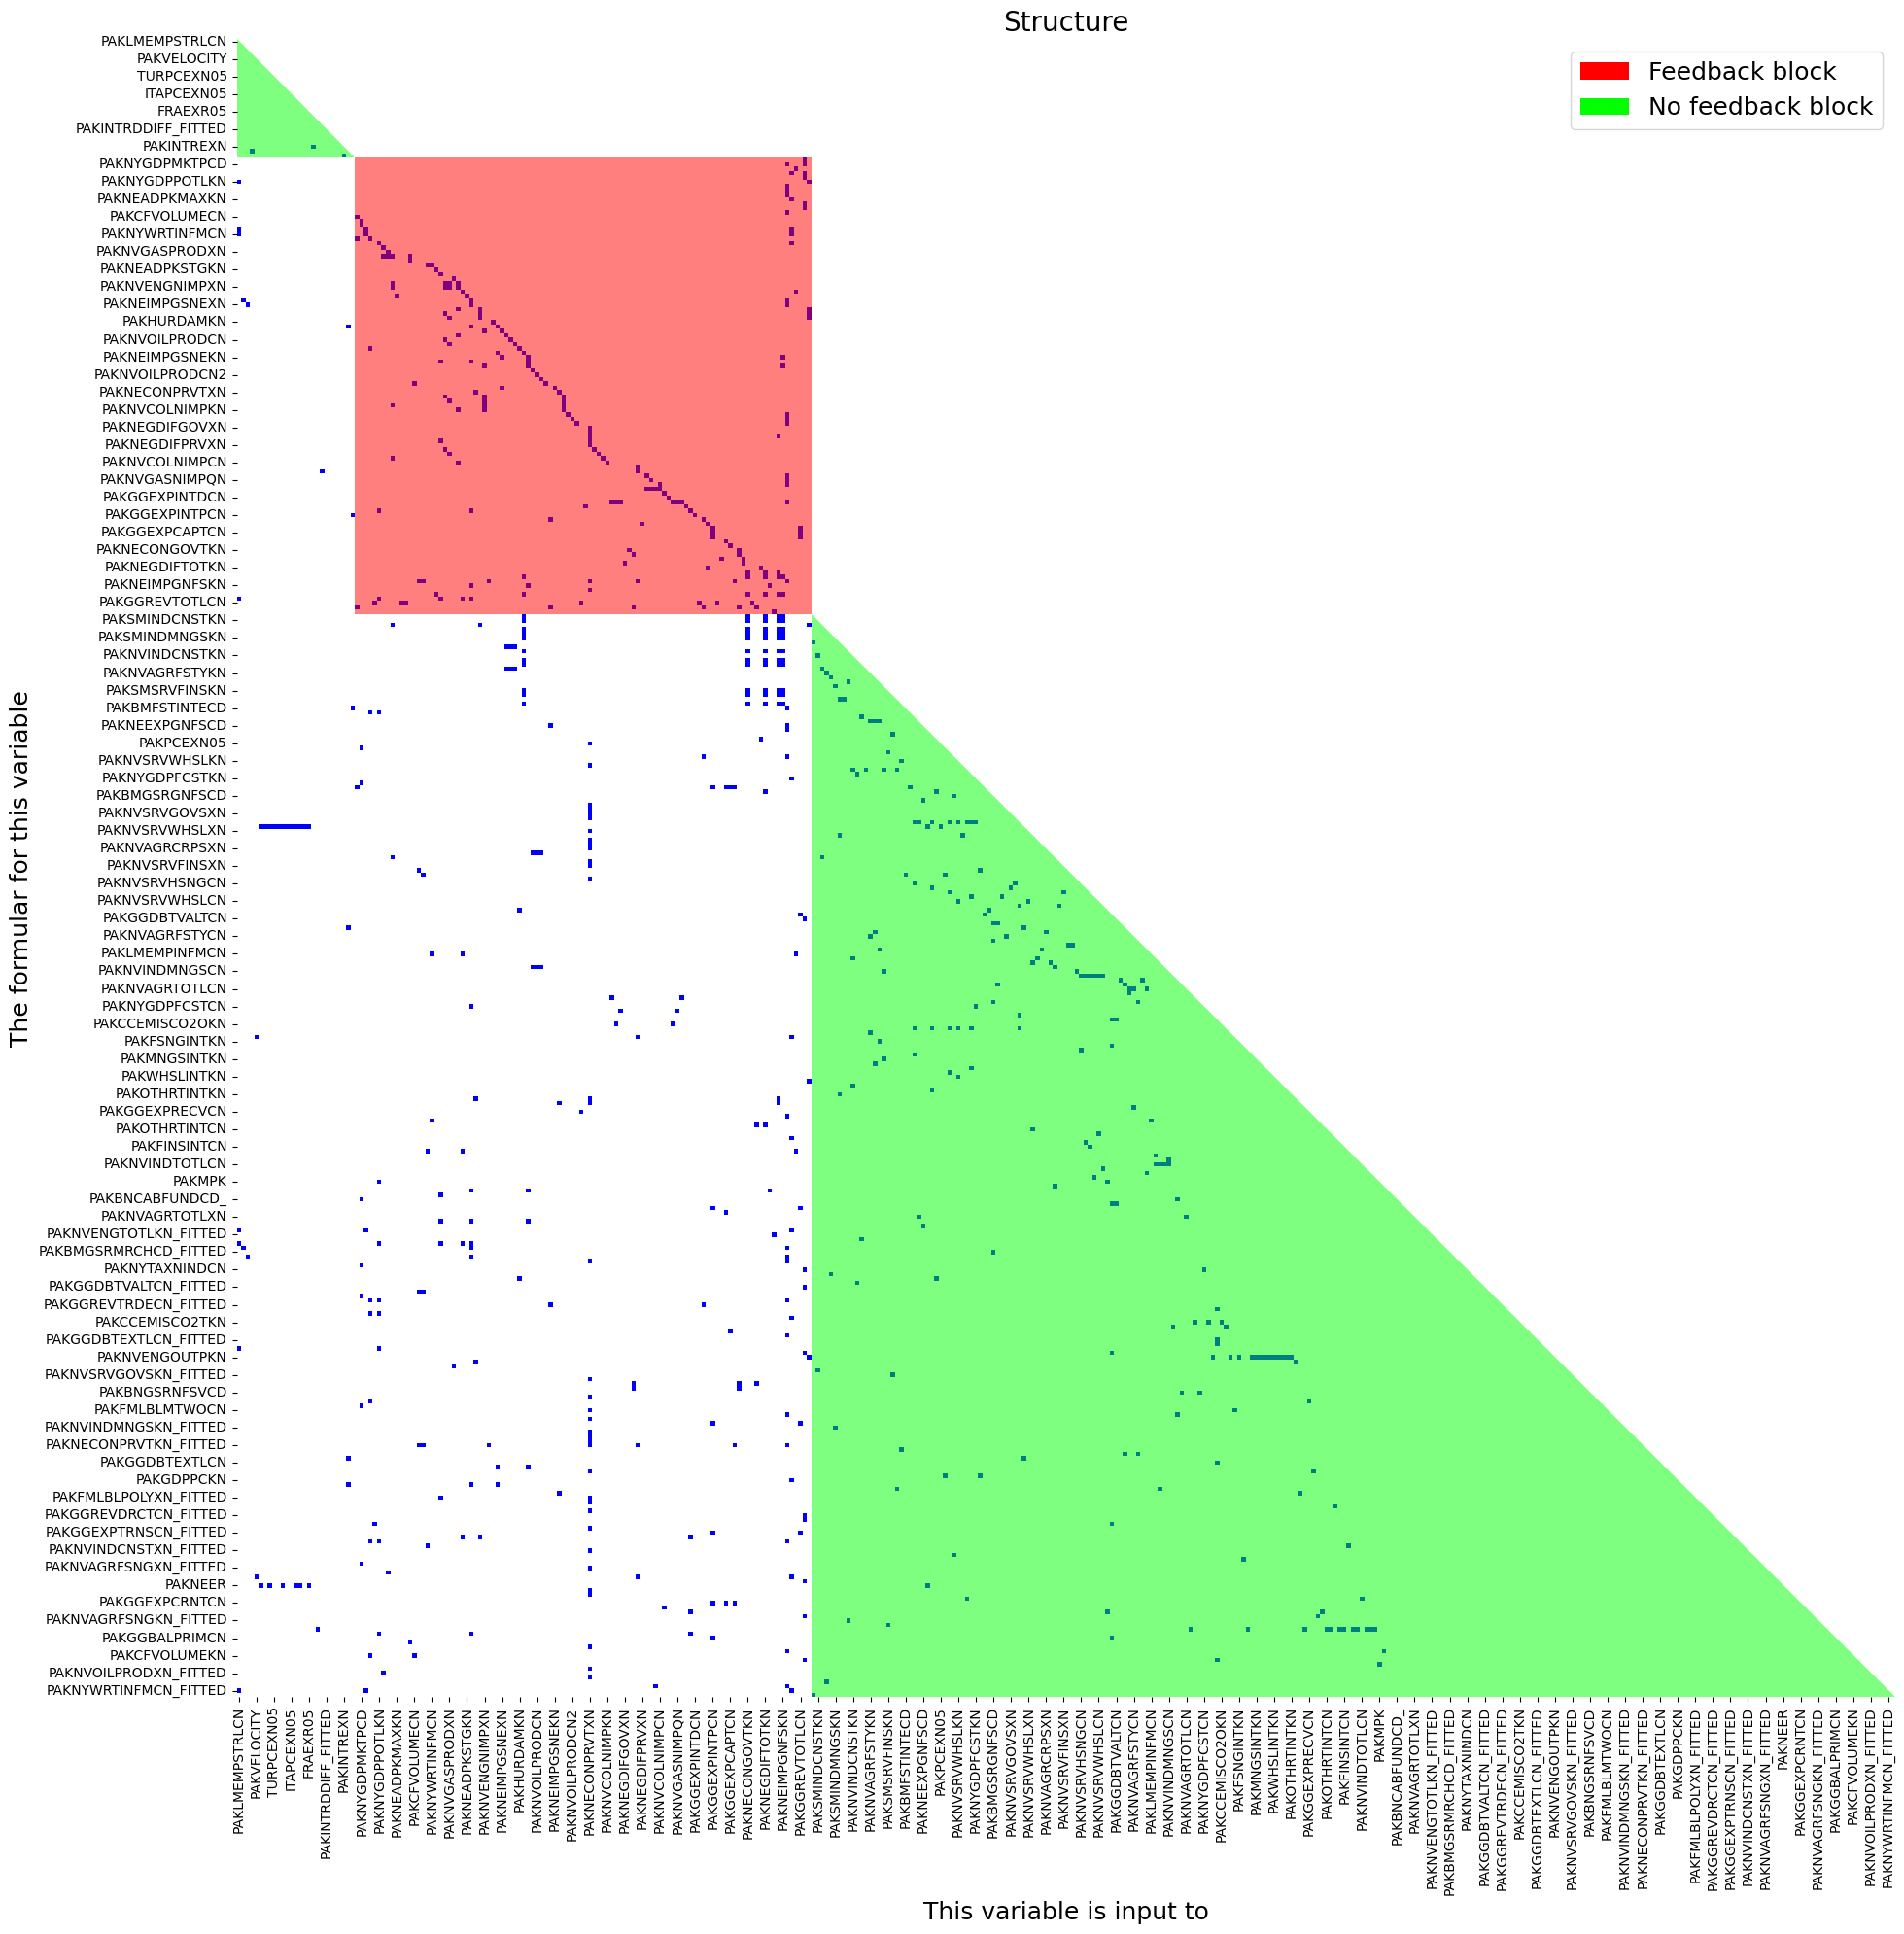

In [6]:
mpak.plotadjacency(size=(20,20),nolag=0);

As is evident in the above chart, the majority of the variables in MFMod Pakistan are recursive (green) and depend simply on the values of other variables.  The core of the model lies in the simultaneous (red) block, where the main wages, prices, real and nominal variables that drive other variables are determined.

:::{index} single: Model Structure; .tracepre() method 
:::
:::{index} single: tracepre(); method trace influnce of causal variables 
:::
:::{index} single: Variable dependencies
:::
:::{index} single: model instance.<variable>; .tracepre() method - trace influence of causal variables 
:::


## The dependencies of individual endogenous variables (the `.tracepre()` method)

As noted above, every endogenous variables is directly dependent on the variables that occur on its right hand side, but is also indirectly dependent on the variables that determine its RHS variables and in turn those that determine the variables to the right of them *ad infinitum*. 

`ModelFlow` includes several methods and properties that allow these dependencies to be explored.

The `.frml` property returns the normalized formula of an equation, from which the right hand variables for the equation can be discerned and these are reported along with their descriptions following the formula.

In [7]:
mpak.PAKNECONPRVTKN.frml

Endogeneous: PAKNECONPRVTKN: HH. Cons Real
Formular: FRML <DAMP,STOC> PAKNECONPRVTKN = (PAKNECONPRVTKN(-1)*EXP(PAKNECONPRVTKN_A+ (-0.2*(LOG(PAKNECONPRVTKN(-1))-LOG(1.21203101101442)-LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1)))+0.763938860758873*((LOG((((PAKBXFSTREMTCD-PAKBMFSTREMTCD)*PAKPANUSATLS)+PAKGGEXPTRNSCN+PAKNYYWBTOTLCN*(1-PAKGGREVDRCTXN/100))/PAKNECONPRVTXN))-(LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1))))-0.0634474791568939*DURING_2009-0.3*(PAKFMLBLPOLYXN/100-((LOG(PAKNECONPRVTXN))-(LOG(PAKNECONPRVTXN(-1)))))) )) * (1-PAKNECONPRVTKN_D)+ PAKNECONPRVTKN_X*PAKNECONPRVTKN_D  $

PAKNECONPRVTKN  : HH. Cons Real
DURING_2009     : 
PAKBMFSTREMTCD  : Imp., Remittances (BOP), US$ mn
PAKBXFSTREMTCD  : Exp., Remittances (BOP), US$ mn
PAKFMLBLPOLYXN  : Key Policy Interest Rate
PAKGG

The method `.tracepre()` provides a graphical representation of this relationship, showing all the variables that directly determine an endogenous variable (in this example real GDP), distinguishing between RHS variables that are endogenous (in blue) and those that are exogenous (yellow).

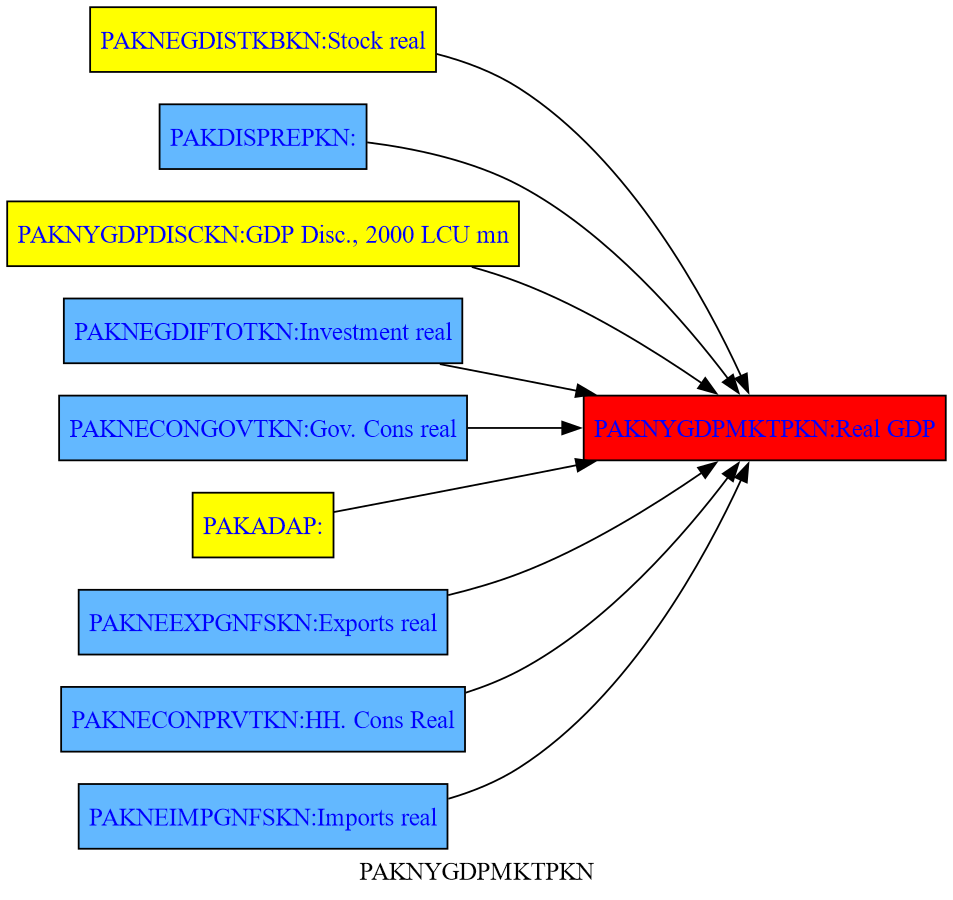

In [8]:
mpak.PAKNYGDPMKTPKN.tracepre(png=latex,size=(4,3))

If the model has been solved, `.tracepre()` goes one step further and reveals the relative importance of each variable in the change of the dependent variable in the preceding scenario.

### Shock the model

Below a $30 nominal Carbon tax is applied beginning in 2025.

In [9]:

alternative  =  baseline.upd("<2025 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")
result = mpak(alternative,2020,2100) # simulates the model 

As a result GDP, consumption investment and most all variables in the model change, as illustrated in the below graphs that show the percent deviation of the main components of GDP from their baseline values.

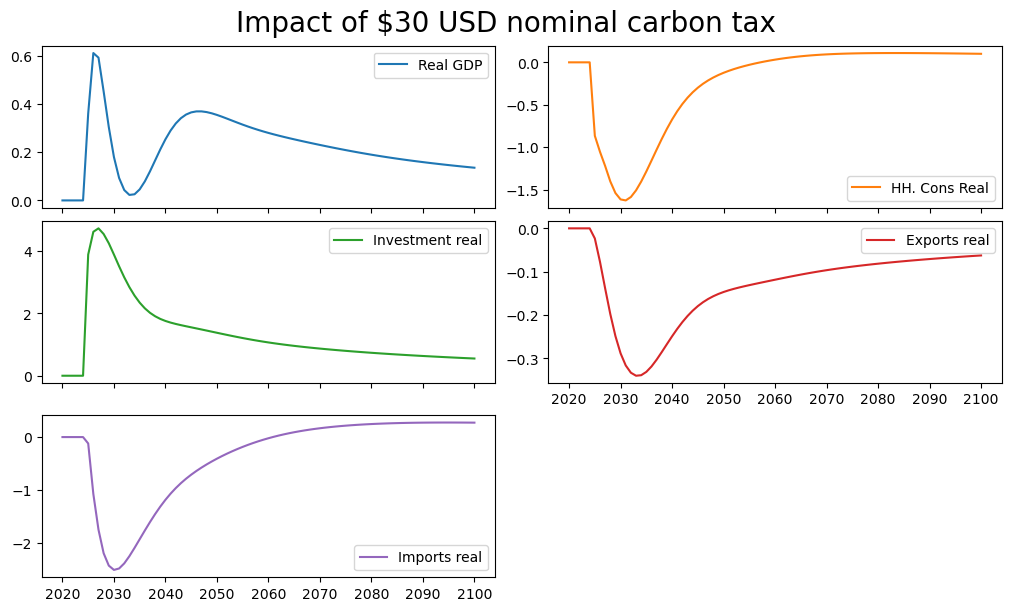

In [10]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNEGDIFTOTKN PAKNEEXPGNFSKN PAKNEIMPGNFSKN'].difpctlevel.rename().plot(title="Impact of $30 USD nominal carbon tax");

:::{index} single: Simulations;  .tracedep() Causal tree at the variable level 
:::
:::{index} single: Model Structure;  .tracedep() Causal tree at the variable level 
:::
:::{index} single: model instance.<variable>;  .tracedep() Causal tree at the variable level 
:::

###  `.tracepre()` following a shock 

Below the same `.tracepre()` command is executed again, but because a shock has been simulated, the width of the lines representing the causal links between variables is thicker the more important the change  in a given variable was in the previous simulation in explaining the change in the level of the dependent variable (GDP).  

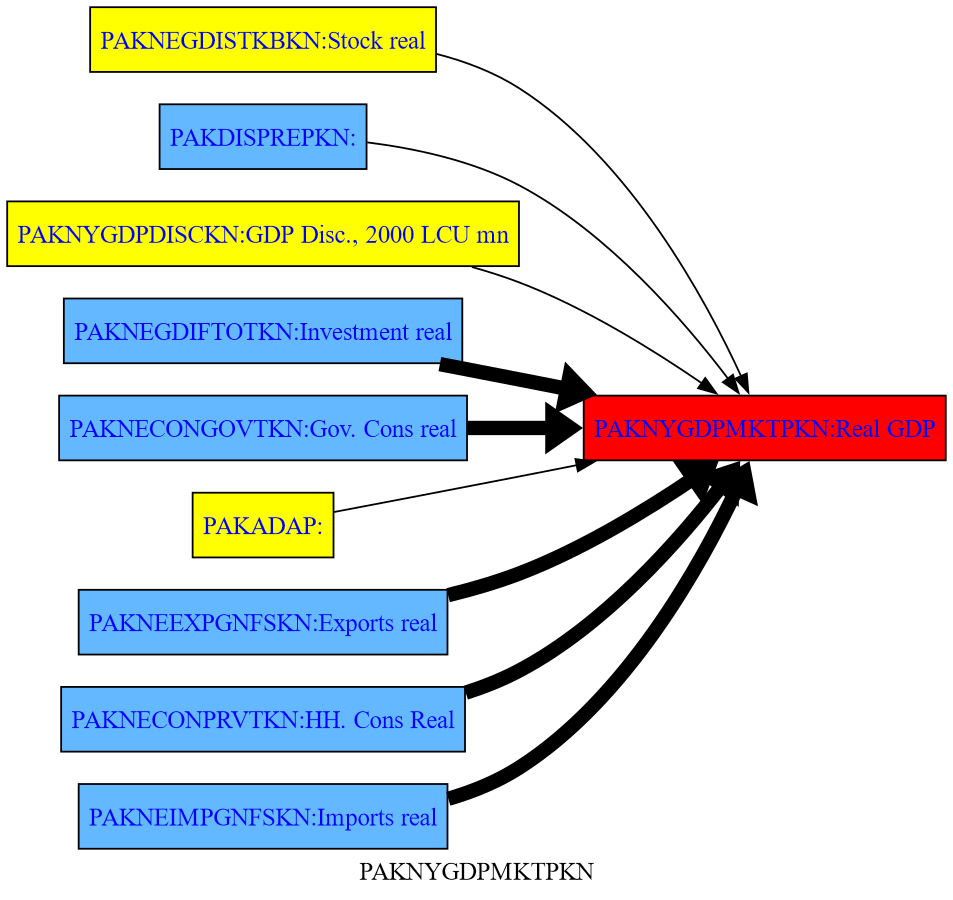

In [11]:
latex=True
mpak.PAKNYGDPMKTPKN.tracepre(png=latex,size=(5,3))

:::{index} single: model instance.<variable>; .tracepre(); filter option restricts output to variables with a large impact 
:::


### The filter option, restricts the output of `.tracepre()`

The filter option can be used to restrict the output of `.tracepre()` to RHS variables that have had a large impact on the dependent variable. In the example below, the option `filter=20` instructs tracepre to only draw those rhs variables that contributed 20 percent or more to the total change in GDP.


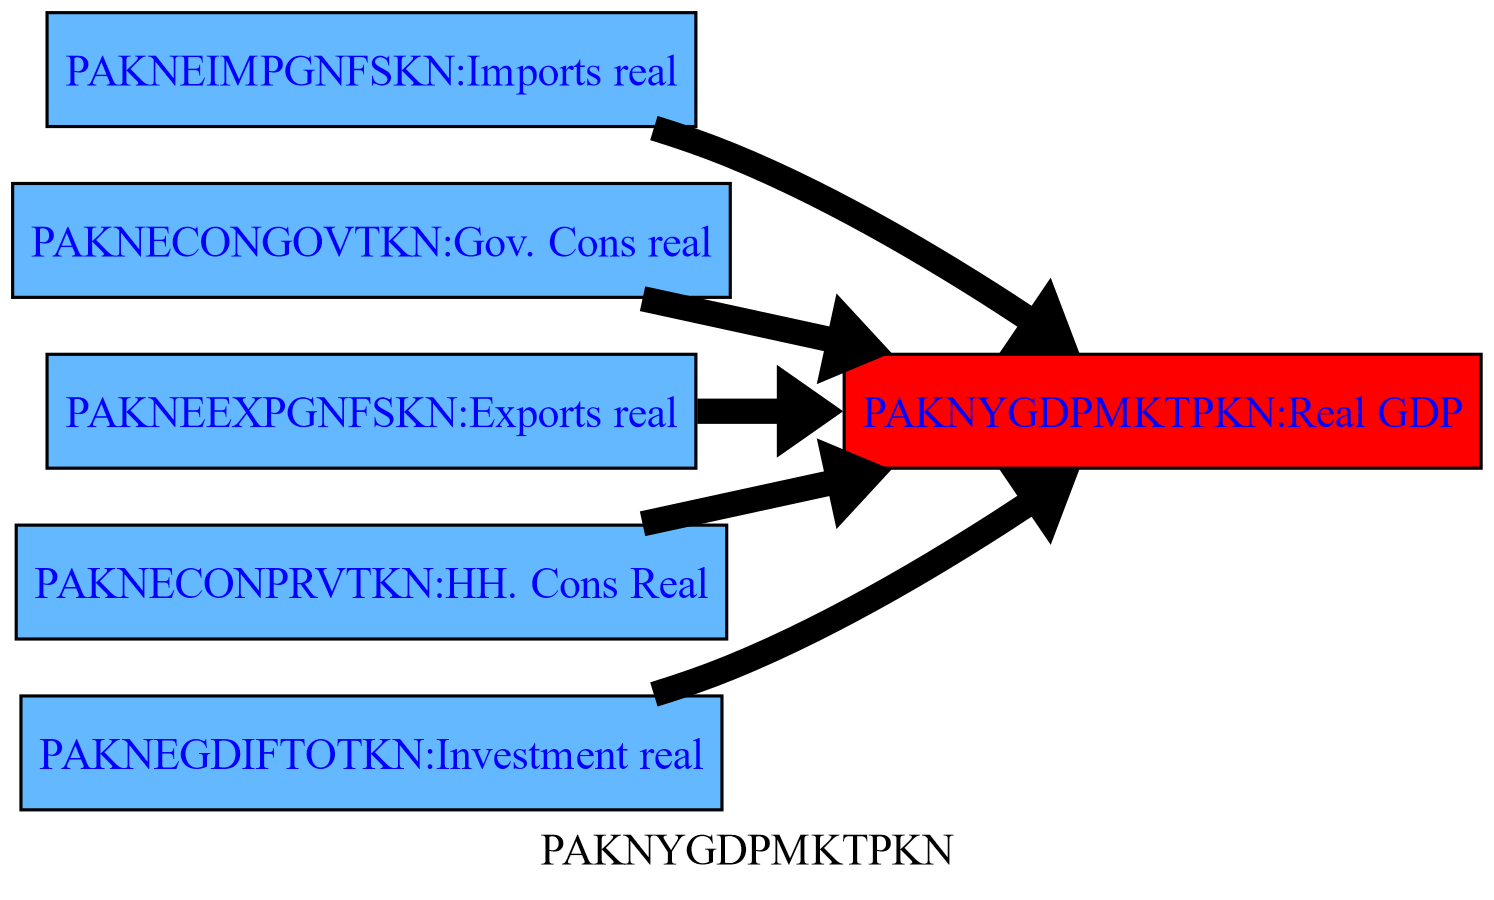

In [12]:
mpak.PAKNYGDPMKTPKN.tracepre(filter=20,png=latex,size=(5,3))

:::{index} model instance.<variable>; tracepre() up option extends the causal tree beyond the initial set of RHS variables
:::


### The up option, extends the `.tracepre` plot beyond the first level of causal variables

The up option allows `.tracepre` dependencies to be followed beyond the first level of causal variables. Below, it is extended to variables as much as three levels back, and restricted to those whose variation explains at least 20 percent of the change in the variable of which they are a right-hand-side variable.

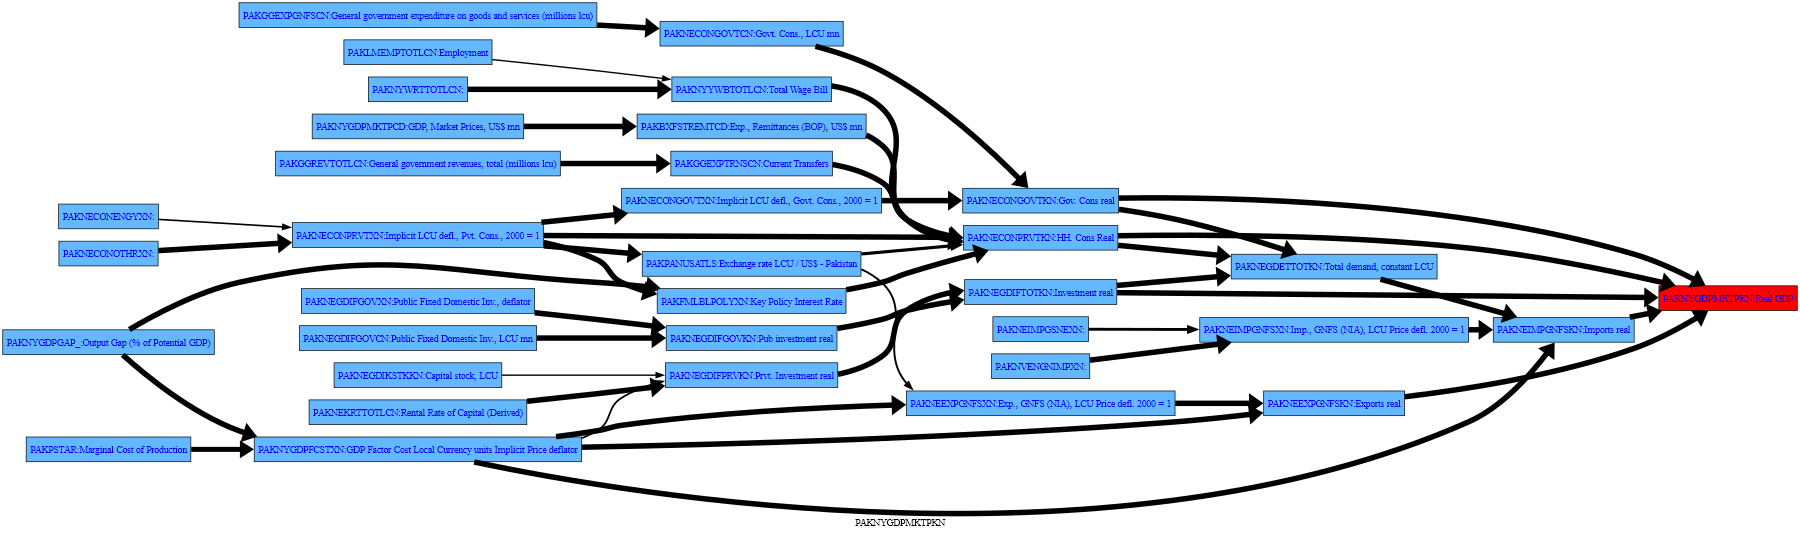

In [13]:
mpak.PAKNYGDPMKTPKN.tracepre(filter = 20,up=3,png=latex)

:::{index} single: model instance.<variable>; .tracepre()  fokus2 option adds a table of impacts to the causal flow graph
:::


#### Adding a table to the causal graph

The `Fokus2` option causes a table of values to be added to the casual flow graph. In this example, the `showgrowth=True` option instructs `ModelFlow` to show the table in both level and growth rate terms.

 

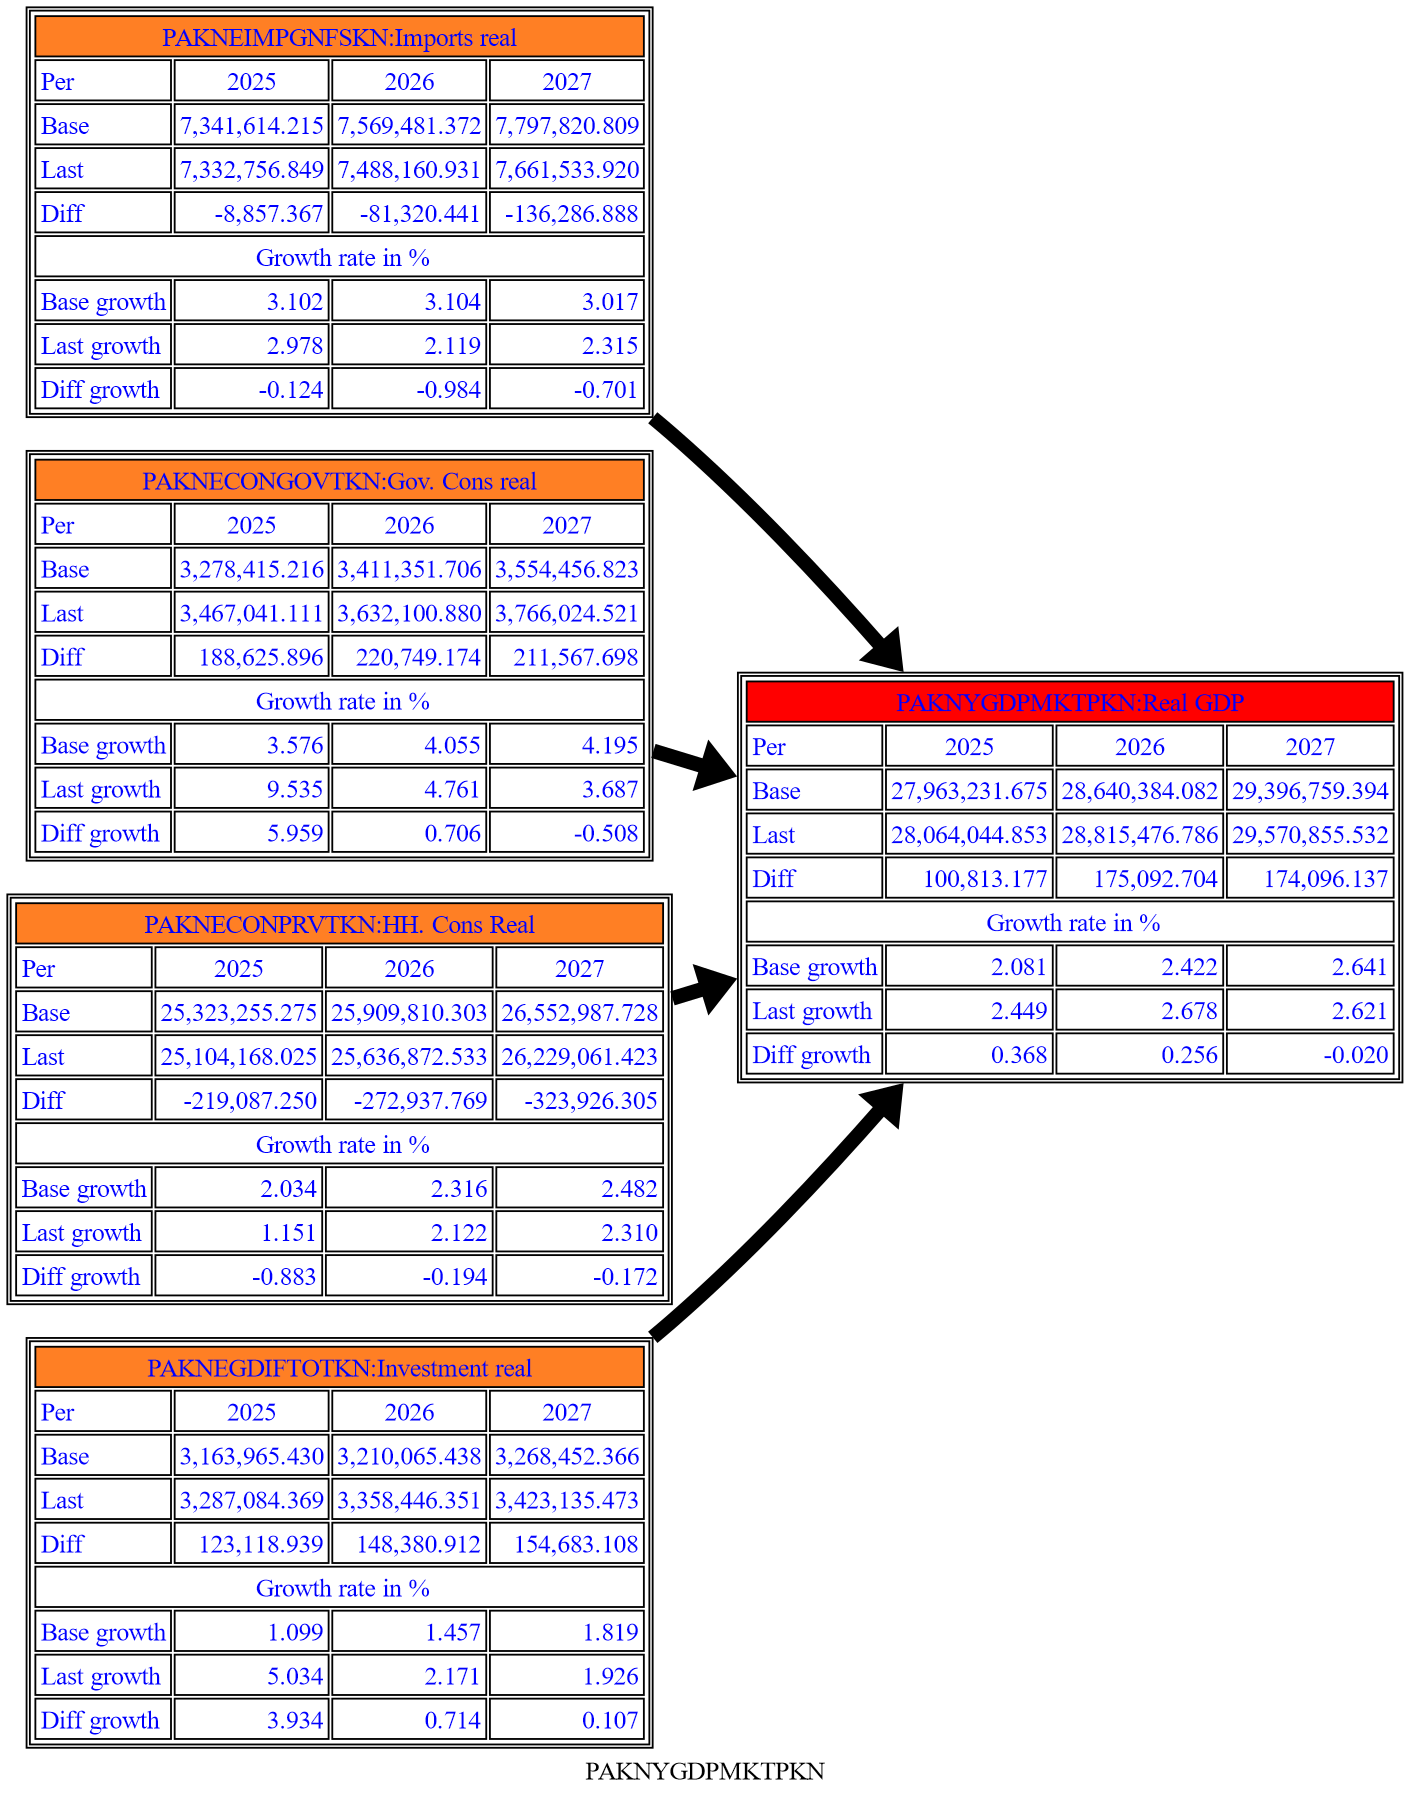

None


In [14]:
with mpak.set_smpl(2025,2027):
    print(mpak.PAKNYGDPMKTPKN.tracepre(filter = 20,fokus2='PAKNEGDIFTOTKN PAKNECONPRVTKN PAKNECONGOVTKN PAKNYGDPMKTPKN PAKNEIMPGNFSKN',growthshow=True,png=latex))

:::{index} single: Model Structure; .tracedep() method
:::
:::{index} single: model instance.<variable>; .tracedep() down option displays the causal tree of variables that are impacted by the referenced variable
:::



### `.tracedep(down=xx)` traces the impact of a variable on other variables 



The preceding examples have focused on understanding how changes in other variables have impacted the variable of interest.  The closely related `tracedep()` method shows what other variables depend on the specified variable, with the `down=xx` option indicating how many levels of substitution to display. Here, the direction of the dependency graph is reversed and the chart shows the impact that the changes in the selected variable had on those which depend upon it.  Below is the impact of change in consumption on all of the variables up to 3 levels below the consumption equation.

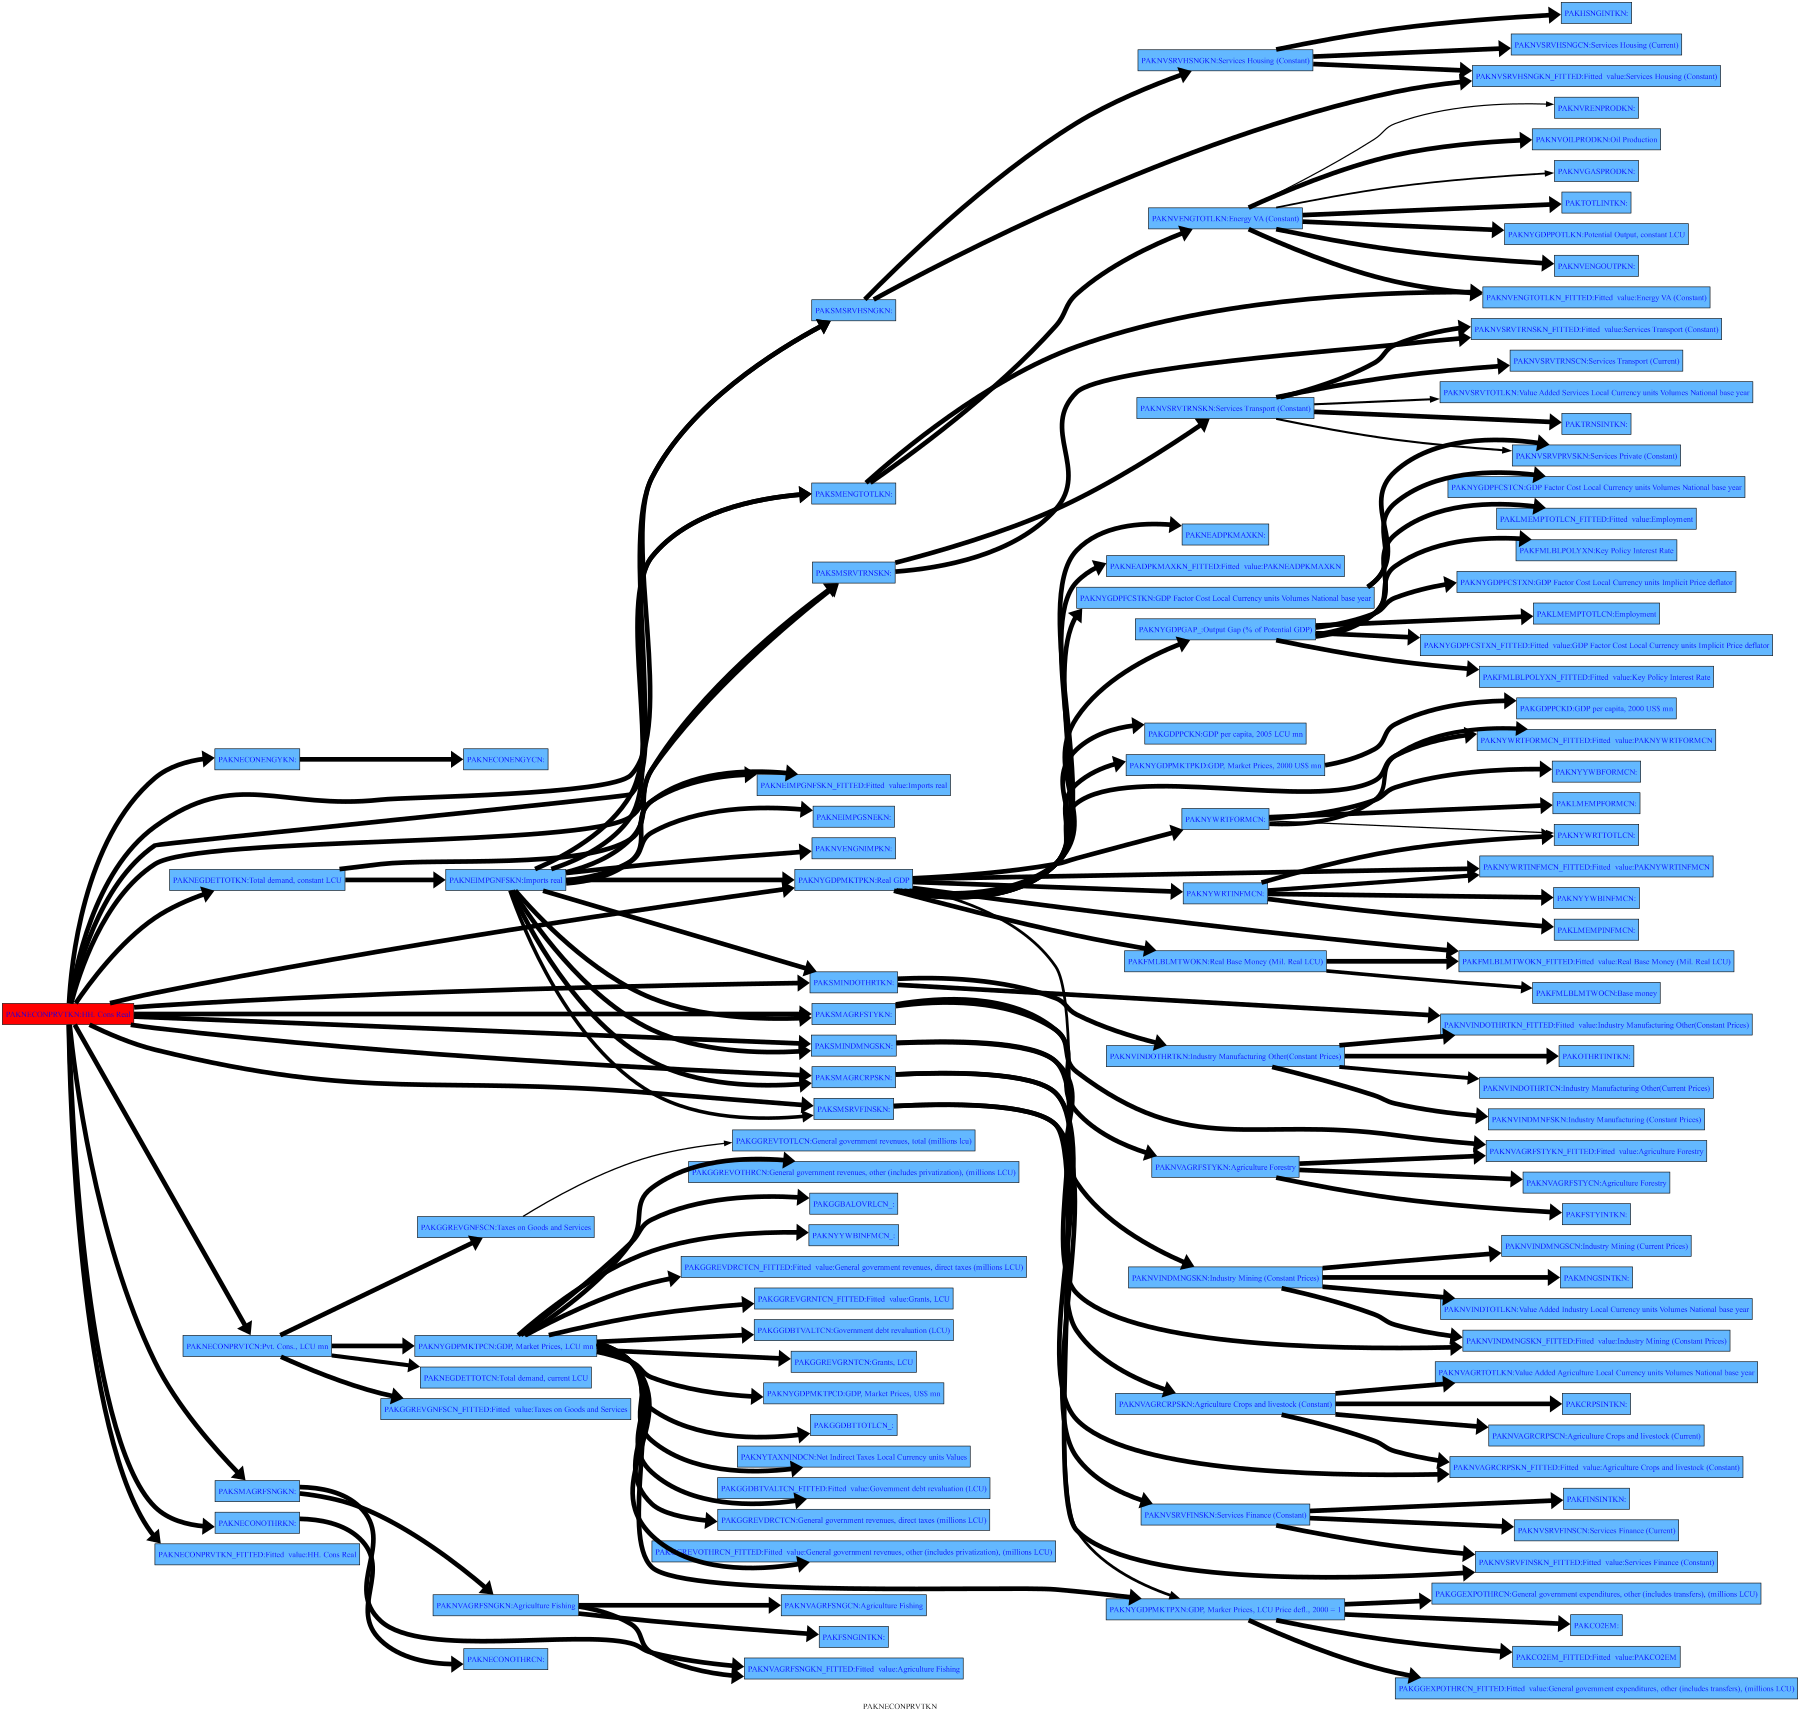

In [15]:
mpak.PAKNECONPRVTKN.tracedep(down=3,filter=20,png=latex)

:::{index}  Model Structure; Modeldash method - an interactive display of linkages within a model.
:::
:::{index}  Modeldash - an interactive display of linkages within a model.
:::

### `.modeldash()` An interactive way to explore dependencies


The `.modeldash()` method  generates a widget that allows you to dynamicaly adjust the arguments to the `tracepre()` and `tracedep` functions.


```
 with mpak.set_smpl(2022,2026):
        mpak.modeldash('PAKNYGDPMKTPKN',jupyter=True,inline=False) 
```

The above commands generate a dashboard that looks a like the below, where the panel to the left allows the user to change options including the filter, the depth of the trace among other things.

![dash.png](dash.png)

In [16]:
try: 
    with mpak.set_smpl(2022,2026):
            mpak.modeldash('PAKNYGDPMKTPKN') 
except:
    ...

Dash app running on http://127.0.0.1:5001/
